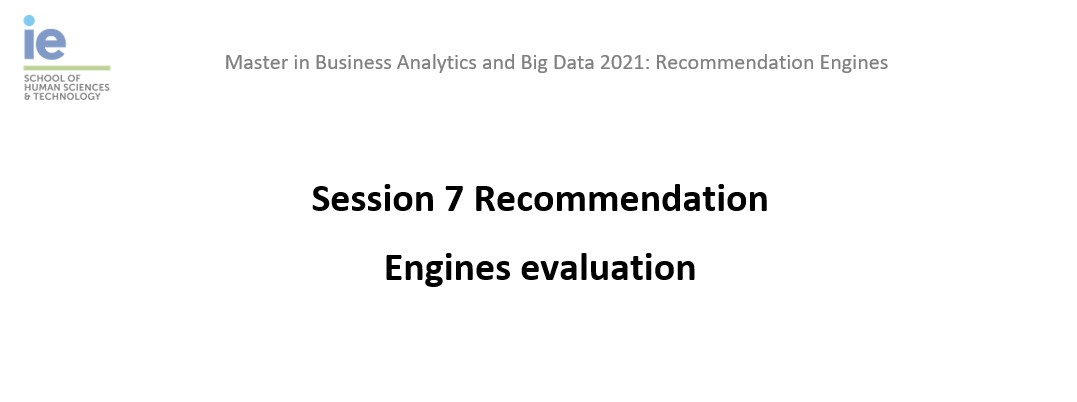

# Splitting the dataset

To evaluate models, we need to build them with some data and test them on some
other data. The surprise package contains prebuilt tools that help us in this task.

The target is to define two datasets, which are as follows:
- **Training set:** This set includes users from which the model learns
- **Test set:** This set includes users to whom we recommend movies

As we saw in session 6 in order to measure model's perfomance is important to have clear if we are using either a **classification (like/dislike) or regression(ratings) approach. Because performance metrics are dependant on the  approach choosen.** 


## Simple split

The easiest way to build a training and test set is to split the data in two parts. First, we need to decide how many users to put into each part. For instance, we can put 80 percent of the users into the training set. We can define percentage_training by specifying the percentage of the training set:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline

from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')


movielens = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\MBD II\\Term 2\\Recommendation Systems\\ml-latest-small\\ratings.csv', parse_dates=['timestamp'])
movielens_meta = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\\MBD II\\Term 2\\Recommendation Systems\\ml-latest-small\\movies.csv')
data = movielens.merge(movielens_meta,on='movieId', how='left')
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [2]:
reader = Reader()
data_surp = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data_surp, test_size=.20)

Here you have two ways of recreating the ratings dataframe from trainset and testset:

In [3]:
test_df=pd.DataFrame(testset, columns=['uid', 'iid', 'rating'])

In [4]:
import pandas as pd

def invert_dictionary(dictionary):
    """Invert a dictionary
    Args: 
        dictionary (dict): A dictionary
    Returns:
        dict: inverted dictionary
    """
    return {v: k for k, v in dictionary.items()}

def surprise_trainset_to_df(trainset, col_user="uid", col_item="iid", col_rating="rating"): 
    df = pd.DataFrame(trainset.all_ratings(), columns=[col_user, col_item, col_rating])
    map_user = trainset._inner2raw_id_users if trainset._inner2raw_id_users is not None else invert_dictionary(trainset._raw2inner_id_users)
    map_item = trainset._inner2raw_id_items if trainset._inner2raw_id_items is not None else invert_dictionary(trainset._raw2inner_id_items)
    df[col_user] = df[col_user].map(map_user)
    df[col_item] = df[col_item].map(map_item)
    return df
train_df=surprise_trainset_to_df(trainset)
train_df.head()

,uid,iid,rating
0,187,44191,3.5
1,187,2997,5.0
2,187,44199,3.5
3,187,1175,4.0
4,187,1214,4.0


### Exercise

Check if both dataset training and test have a similar distribution (histogram)

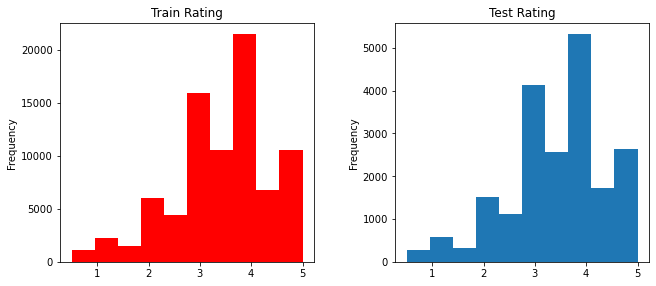

In [18]:
## Distribution graphical Analysis

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
fig.tight_layout(pad=5.0)

train_df['rating'].plot(kind='hist', color='red', ax=ax[0]).set_title('Train Rating');
test_df['rating'].plot(kind='hist', ax=ax[1]).set_title('Test Rating');

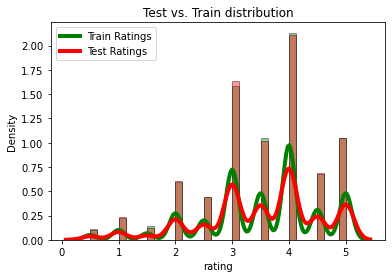

In [21]:
# Alternative frequency comparison

sns.distplot(train_df['rating'], hist=True, kde=True, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

sns.distplot(test_df['rating'], hist=True, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set(title='Test vs. Train distribution')

plt.legend(labels=["Train Ratings","Test Ratings"]);

---
**Observation**

As we may notice, both the train and the test follow and almost identical shape. The difference in frequency is due to the sample size but, we can conclude from the histogram that rating distribution is balanced.

---

## K-fold validation 


The previous approach tested the recommender on part of the users. If, instead, we test the recommendation on each user, we could measure the
performances much more accurately. We can split the data into some chunks, take a chunk out as the test set, and evaluate the accuracy. Then, we can do the same with each other chunk and compute the average accuracy. This approach is called k-fold
and it's supported by surprise.

An example a k-fold validation wiht K=5 is provided below. 
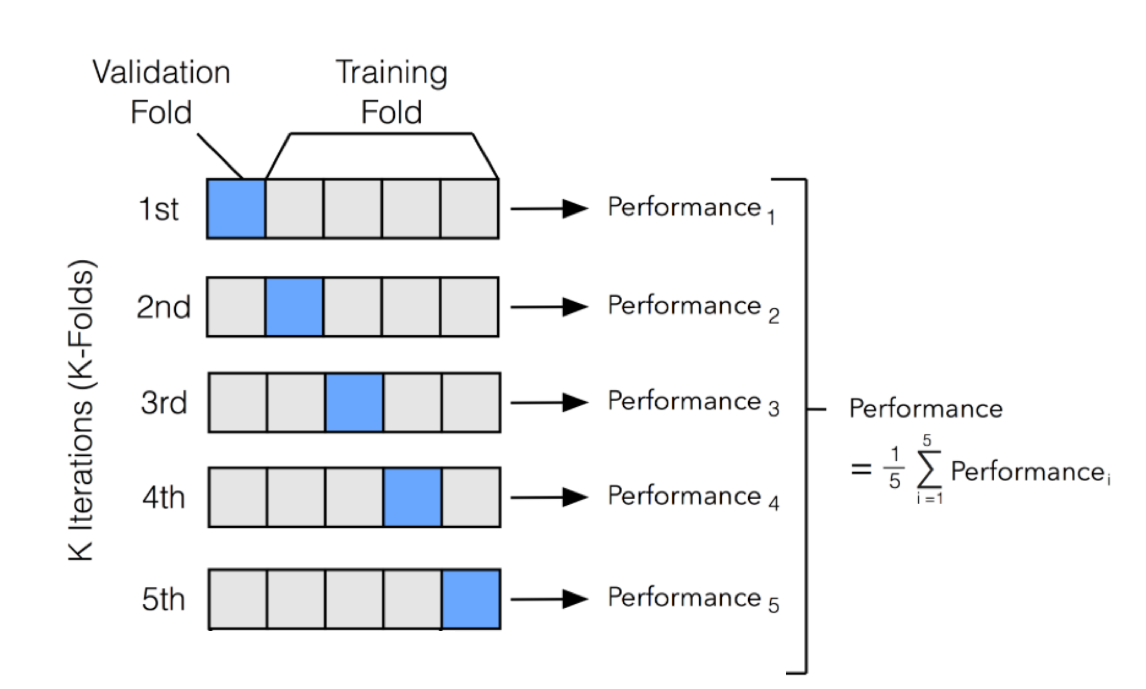

Here is an example where we use a classical K-fold cross-validation procedure with 3 splits:

In [3]:
from surprise.model_selection import KFold
kf = KFold(n_splits=3)

alg = KNNBasic()

for trainset, testset in kf.split(data_surp):

    # train and test algorithm.
    alg.fit(trainset)
    predictions = alg.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
    

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9590
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9545
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9594


### Exercise 
In previous code we split our original dataset using a k-fold validation schema, k=3. Can you create a leave one out schema?
Tip: Use LeaveOneOut from model_selection

In [8]:
## Importing the Model
from surprise.model_selection import LeaveOneOut

# Calling the model loo (leave one out) and the algorithm at use (KNNBasic)

loo = LeaveOneOut(n_splits=3, min_n_ratings=2)
algo = KNNBasic()

for trainset, testset in loo.split(data_surp):
    algo.fit(trainset)
    predictions_loo = algo.test(testset)
    accuracy.rmse(predictions_loo, verbose=True)
    accuracy.mae(predictions_loo, verbose=True);

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9586
MAE:  0.7510
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9611
MAE:  0.7362
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9635
MAE:  0.7533


# Evaluation Recommenders

To measure the accuracy we can use the following:
- Root mean square error (RMSE): This is the standard deviation of the difference between the real and predicted ratings (errors).
\begin{equation} 
RMSE = \sqrt{\frac{\sum_{i=1}^{N}{e_i^2}}{N}}
\end{equation}
- Mean squared error (MSE): This is the mean of the squared difference between the real and predicted ratings. It's the square of RMSE, so it contains
the same information
\begin{equation} 
MSE = \frac{\sum_{i=1}^{N}{({e})^2}}{N}
\end{equation}
- Mean absolute error (MAE): This is the mean of the absolute difference between the real and predicted ratings.
\begin{equation} 
\frac{1}{n}\sum_{i=1}^{N}|e_i|
\end{equation} 

One example on how to do it is the following:

In [9]:
knn = KNNBasic()
predictions = knn.fit(trainset).test(testset)
accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9635


0.9635383109764006

## Exercise
Change the accuracy metric to MAE and explain the difference.

In [10]:
# Applying the MAE accuracy metric
knn = KNNBasic()
predictions = knn.fit(trainset).test(testset)
accuracy.mae(predictions, verbose=True)
accuracy.rmse(predictions, verbose=True);

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7533
RMSE: 0.9635


---
**Explanation**

Both the MAE and RSME express in the average model prediction error, without considering the direction of the error (since they are squared or in absolut values). Nevertheless, the key difference between these accuracy metrics consists on how they weight the error. 

The RSME, by squaring the predictions error before applying the square root will apply a relatively high weight to large errors, whereas the MAE considers all individual differences to have an equal weight. As a result of this differences in weights, we are able to observe a larger RMSE than a MAE - as is the general case -. 

---

## Exercise 
Compute these measures for each user

In [4]:
import numpy as np

# Creating the error computation functions:

def rsme(error):
    return np.sqrt((np.power(error, 2)).mean())

def mae(error):
    return ((np.absolute(error)).mean())

In [13]:
# Create a dataframe with the predictions and estimations:

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

# Creating an error variable to compute accuracy measures:
df['error'] = df['est'] - df['rui']
df = df.sort_values(by='uid', ascending=True)

# Creating corresponding RSME and MAE per user variables
user_rsme = df.groupby('uid').apply(lambda x: rsme(x['error']))
user_mae = df.groupby('uid').apply(lambda x: mae(x['error']))

# Cleaning the results for expanded computation and visual
user_rsme = user_rsme.to_frame();
user_mae = user_mae.to_frame();

user_rsme = pd.DataFrame(user_rsme.to_records())
user_mae = pd.DataFrame(user_mae.to_records())

user_rsme.rename({'0': 'rsme'}, axis=1, inplace=True)
user_mae.rename({'0': 'mae'}, axis=1, inplace=True)


In [14]:
print('Mean Average Error:', user_mae.mae.mean())
print('Root Square Mean Error:', user_rsme.rsme.mean())

Mean Average Error: 0.7625624842474776
Root Square Mean Error: 0.9395645375601611


In [15]:
print(user_rsme.head())
print("")
print('*'*10)
print("")
print(user_mae.head())

   uid      rsme
0    1  1.164815
1    2  1.095570
2    3  2.230306
3    4  1.271372
4    5  0.870971

**********

   uid       mae
0    1  0.961476
1    2  1.007114
2    3  2.056203
3    4  1.009914
4    5  0.710125


By looking at the first 5 users, we can observe that the RSME is always larger than the MAE - which coincides with the difference in weights explained previously.

## Exercise 

Draw a distribution graph of the errors. Comment the results

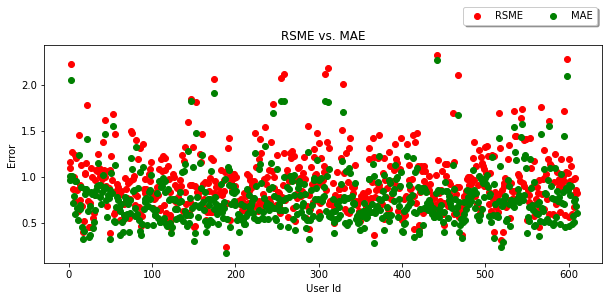

In [16]:
## Scatter plot contrasting RSME and MAE values per user

fig,ax = plt.subplots(figsize=(10,4)) 
ax.scatter(user_rsme.uid, user_rsme.rsme.values, color='red', label='RSME') 
ax.scatter(user_mae.uid, user_mae.mae.values, color='green', label = 'MAE')
plt.xlabel('User Id')
plt.ylabel('Error')
plt.title('RSME vs. MAE')
plt.legend(bbox_to_anchor=(1, 1.2),
          ncol=3, fancybox=True, shadow=True);

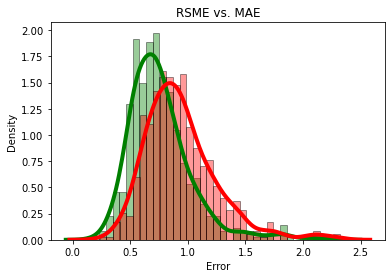

In [17]:
## Density graph to contrast peaking and evolution

sns.distplot(user_mae['mae'], hist=True, kde=True, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

sns.distplot(user_rsme['rsme'], hist=True, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set(title='RSME vs. MAE', xlabel='Error');



---
**Explanation**

From the scatter plot (fig. 1) we can observe that most of the errors per user in the model oscillate around an error of 1 rating. This is consistent with the previous results where we obtained that the MAE was ~.76 and the RSME ~.94. This particular difference is what describes a higher density for the MAE at a lower bound and peaking higher than the RSME as can be observed from the density plot (fig. 2). 

As mentioned previously, the RSME by squaring the errors punishes large errors more harshly than minor errors. Thus we can observe from the individual error scatterplot that, while most of the points are close to each other - there are some exceptions which lead to certain points (as the one near user 1 or to the left of user 500) which show a more pronounced relative distance between the MAE point and the RSME point.

Finally, It is important to notice that running the `LeaveOneOut`model will provide identical MAE and RSME since the model consists in leaving a rating out of the dataset, calculating its estimate and then averaging these calculations. Which leads to a mathematical equivalnce for the RSME and the MAE.

---

# Evaluating the recommendation


Another way to measure accuracies is by comparing the recommendations with the purchases having a positive rating. We need to define a threshold for positive ratings

Let's recap the metrics for classification. 

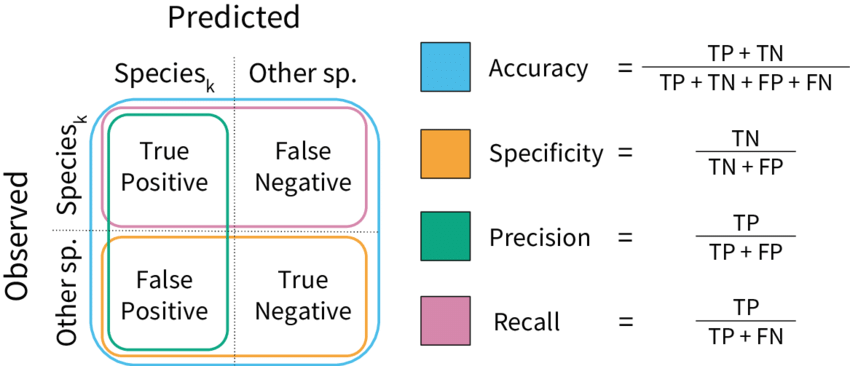

First, let's build the ROC curve. It displays these factors:
- **True Positive Rate (TPR):** This is the percentage of rated items that have been recommended. It's the number of TP divided by the number of rated items (TP + FN).
- **False Positive Rate (FPR)**: This is the percentage of not rated items that have been recommended. It's the number of FP divided by the number of not
rated items (FP + TN).

- **Precision:** This is the percentage of recommended items that have been rated. It's the number of FP divided by the total number of positives (TP + FP).
- **Recall:** This is the percentage of purchased items that have been recommended. It's the number of TP divided by the total number of rated (TP + FN). It's also equal to the True Positive Rate.

In [18]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [18]:
from surprise import KNNBasic
from surprise.model_selection import KFold


kf = KFold(n_splits=5)
alg = KNNBasic()

for trainset, testset in kf.split(data_surp):
    alg.fit(trainset)
    predictions = alg.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.1)

    # Precision and recall can then be averaged over all users
    print("Precision:"+str(sum(prec for prec in precisions.values()) / len(precisions)))
    print("Recall:"+str(sum(rec for rec in recalls.values()) / len(recalls)))
    

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7718852459016418
Recall:0.4617995735860789
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7741776315789499
Recall:0.4452968421641523
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7576902025177907
Recall:0.44847007831502017
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.773032786885248
Recall:0.46424205659957174
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7669672131147566
Recall:0.4628372078684605


## Exercise
Change the previous code to increase the Recall. Explain your results

In [19]:
kf = KFold(n_splits=5)
alg = KNNBasic()

for trainset, testset in kf.split(data_surp):
    alg.fit(trainset)
    predictions = alg.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.1)

    # Precision and recall can then be averaged over all users
    print("Precision:"+str(sum(prec for prec in precisions.values()) / len(precisions)))
    print("Recall:"+str(sum(rec for rec in recalls.values()) / len(recalls)))
    

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7428558417902685
Recall:0.6213459615364453
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7480491046993507
Recall:0.6375926514107579
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7465775435857406
Recall:0.6158693747914459
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7448406193078329
Recall:0.6364017227602218
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.744544139494879
Recall:0.6292871125062389


---
**Explanation**

To increase the recall on this model, a simple adjustment consists in increasing the number of offered products to the user which would thus reduce the False Negative's in the model. In other words, it is easier to show users a relevant movie if the list of movies presented is more extensive. The larger the universe of items presented, it will lead to a higher true positive rate. Nevertheless, this has a cost of reducing the precision of the model - where we can observe that duplicating the number of items, lead to a fall in precision of 0.04. 

The mix/balance of recall and precision is something that the model should take into account when defining these aspects.

---

## Comparing model and identifying the best

In order to evaluate different models, we can define a list with them. 

In [20]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(),KNNBasic(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,test_rmse,fit_time,test_time
Algorithm,,,
KNNWithMeans,0.903647,0.102729,1.938168
KNNWithZScore,0.903704,0.145632,2.054896
KNNBasic,0.955740,0.093127,1.783408
KNNBasic,0.956577,0.091426,1.491394
KNNBasic,0.957850,0.089333,1.409329


## Exercise
Compute the benchmark using the best options you got in your parameter tunning for each algorithm

**KNNWithMeans Parameter Tunning**

In [8]:
# Using a GridSearchCV to find the best parameters (applying so many options led the model not to work)

param_grid = {'k': [2, 5, 10, 15, 20, 25, 30, 40, 60, 80],
             'min_k': [0,1,2, 3, 4, 5],
#               'bsl_options': {'method': ['als'], # Alternating Least Squares method
#                               'n_epochs': [1, 5, 10],
#                               'reg_u': [10, 15, 20, 25], #shrinkage parameter for users (default = 10)
#                               'reg_i': [15, 25, 30, 40]}, #shrikage parameter for items (default = 15)
               'sim_options': {'name': ['pearson_baseline', 'cosine']}}  
                              #'user_based': [True, False]}}  Is the model better comparing users or movies

             
knnwithmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
knnwithmeans_gs.fit(data_surp)

In [16]:
results_wm = pd.DataFrame.from_dict(knnwithmeans_gs.cv_results)

In [10]:
# Obtaining the parameters
algo = knnwithmeans_gs.best_estimator['rmse']  # pass the best model to algo
print(knnwithmeans_gs.best_params)
print(knnwithmeans_gs.best_score['rmse'])
print(knnwithmeans_gs.best_params['rmse'])
cross_validate(algo, data_surp, measures=['RMSE', 'MAE'], cv=5, verbose=False)

{'rmse': {'k': 30, 'min_k': 4, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}}
0.8864359793138379
{'k': 30, 'min_k': 4, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.88948691, 0.87829556, 0.88681965, 0.88574869, 0.89818767]),
 'test_mae': array([0.67506139, 0.66678742, 0.67280411, 0.67244332, 0.67913543]),
 'fit_time': (0.4372081756591797,
  0.4431755542755127,
  0.44153809547424316,
  0.4423794746398926,
  0.4502549171447754),
 'test_time': (0.9193234443664551,
  0.886298656463623,
  0.8932993412017822,
  0.948361873626709,
  0.9265530109405518)}

**Best Parameters WithMeans**

- 'k': 30, 
- 'min_k': 4, 
- 'sim_options':'pearson_baseline', 
- 'user_based': True

*RSME: 0.8864359793138379*

**KNNWithZScore Parameter Tunning**

In [11]:
param_grid = {'k': [2, 5, 10, 15, 20, 25, 30, 40, 60, 80],
             'min_k': [0,1,2, 3, 4, 5],
              'sim_options': {'name': ['pearson_baseline', 'cosine']}}

knnzscore_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
knnzscore_gs.fit(data_surp)

In [14]:
results_zs = pd.DataFrame.from_dict(knnzscore_gs.cv_results)

In [19]:
# Obtaining the parameters for KNNZScore
algo = knnzscore_gs.best_estimator['rmse']  # pass the best model to algo
print(knnzscore_gs.best_params)
print(knnzscore_gs.best_score['rmse'])
print(knnzscore_gs.best_params['rmse'])
cross_validate(algo, data_surp, measures=['RMSE', 'MAE'], cv=5, verbose=False)

{'rmse': {'k': 30, 'min_k': 3, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}}
0.8842850294338949
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.88012258, 0.885803  , 0.89105061, 0.87885746, 0.88455916]),
 'test_mae': array([0.6656531 , 0.66792543, 0.67070337, 0.66378634, 0.6666719 ]),
 'fit_time': (0.4497182369232178,
  0.501401424407959,
  0.48203063011169434,
  0.5098230838775635,
  0.4858880043029785),
 'test_time': (0.9865584373474121,
  0.9903006553649902,
  0.9857244491577148,
  1.0024738311767578,
  1.0754485130310059)}

**Best Parameters Z-Score**

- 'k': 30,
- 'min_k': 3,
- 'sim_options':'pearson_baseline',
- 'user_based': True

*RSME: 0.8842850294338949*

**KNNBasic Parameter Tunning**

In [18]:
param_grid = {'k': [2, 5, 10, 15, 20, 25, 30, 40, 60, 80],
             'min_k': [1,2, 3, 4, 5],
              'sim_options': {'name': ['pearson_baseline', 'cosine']}}

knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
knnbasic_gs.fit(data_surp)

In [28]:
results_kb = pd.DataFrame.from_dict(knnbasic_gs.cv_results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.067014,1.064448,1.084345,1.065049,1.071607,1.070493,0.007368,98,0.769097,0.006374,0.984162,0.019805,"{'k': 2, 'min_k': 1, 'sim_options': {'name': '...",2,1,"{'name': 'pearson_baseline', 'user_based': True}"
1,1.103403,1.113694,1.117663,1.108703,1.107573,1.110207,0.004965,100,0.654457,0.013999,1.007225,0.039905,"{'k': 2, 'min_k': 1, 'sim_options': {'name': '...",2,1,"{'name': 'cosine', 'user_based': True}"
2,1.060501,1.056203,1.076229,1.059329,1.064319,1.063316,0.006960,97,0.792081,0.013586,1.095740,0.133716,"{'k': 2, 'min_k': 2, 'sim_options': {'name': '...",2,2,"{'name': 'pearson_baseline', 'user_based': True}"
3,1.097303,1.108362,1.110627,1.102630,1.101547,1.104094,0.004809,99,0.753365,0.061906,1.032088,0.111963,"{'k': 2, 'min_k': 2, 'sim_options': {'name': '...",2,2,"{'name': 'cosine', 'user_based': True}"
4,1.035666,1.042293,1.041941,1.050402,1.042294,1.042519,0.004681,95,0.860949,0.072494,1.071720,0.117226,"{'k': 2, 'min_k': 3, 'sim_options': {'name': '...",2,3,"{'name': 'pearson_baseline', 'user_based': True}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.959863,0.967034,0.971171,0.969971,0.967353,0.967078,0.003931,36,1.090512,0.074159,3.465545,0.122409,"{'k': 80, 'min_k': 3, 'sim_options': {'name': ...",80,3,"{'name': 'cosine', 'user_based': True}"
96,0.958035,0.959859,0.969560,0.968292,0.964464,0.964042,0.004523,10,1.218390,0.058506,3.058586,0.102105,"{'k': 80, 'min_k': 4, 'sim_options': {'name': ...",80,4,"{'name': 'pearson_baseline', 'user_based': True}"
97,0.961763,0.966978,0.972775,0.972856,0.968548,0.968584,0.004121,44,1.107459,0.062581,3.564029,0.221787,"{'k': 80, 'min_k': 4, 'sim_options': {'name': ...",80,4,"{'name': 'cosine', 'user_based': True}"
98,0.960814,0.962345,0.971929,0.971247,0.966131,0.966493,0.004511,29,1.236525,0.092045,3.109877,0.269459,"{'k': 80, 'min_k': 5, 'sim_options': {'name': ...",80,5,"{'name': 'pearson_baseline', 'user_based': True}"


In [21]:
# Obtaining the parameters for KNNBasic
algo = knnbasic_gs.best_estimator['rmse']  # pass the best model to algo
print(knnbasic_gs.best_params)
print(knnbasic_gs.best_score['rmse'])
print(knnbasic_gs.best_params['rmse'])
cross_validate(algo, data_surp, measures=['RMSE', 'MAE'], cv=5, verbose=False)

{'rmse': {'k': 40, 'min_k': 3, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}}
0.9633195560287217
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.96675918, 0.95600092, 0.96254476, 0.97152604, 0.95608981]),
 'test_mae': array([0.74747971, 0.73916956, 0.7440526 , 0.74843381, 0.73814791]),
 'fit_time': (0.41864562034606934,
  0.44393157958984375,
  0.43473386764526367,
  0.42574119567871094,
  0.4562671184539795),
 'test_time': (0.8729491233825684,
  0.990222692489624,
  0.8752090930938721,
  0.9608385562896729,
  0.8724582195281982)}

**Best Parameters**

- 'k': 40,
- 'min_k': 3,
- 'sim_options':'pearson_baseline',
- 'user_based': True

*RSME: 0.9633195560287217*


By tunning the parameters - KNNWithZScore offers a model with marginally less RSME than KNNWithMEans

**Added Model Test: SVD & SVDpp**

To determine which is the best model to tune and obtain the best results the matrix factorization based algorithms from Surprise will be considered. These models apply stochastic gradient descent as its learning parameter and mapping to understand the underlying representation of relationship between users and items. 

In [4]:
from surprise import SVD

**SVD**

In [5]:
param_grid = {'n_factors': [15, 25, 50, 80, 100],
              'n_epochs': [20, 60, 80, 100],
              'init_std_dev':[0.005, 0.01, 0.1]}

SVD_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
SVD_gs.fit(data_surp)

In [6]:
results_svd = pd.DataFrame.from_dict(SVD_gs.cv_results)

In [7]:
# Obtaining the parameters for SVD
algo = SVD_gs.best_estimator['rmse']  # pass the best model to algo
print(SVD_gs.best_params)
print(SVD_gs.best_score['rmse'])
print(SVD_gs.best_params['rmse'])
cross_validate(algo, data_surp, measures=['RMSE', 'MAE'], cv=5, verbose=False)

{'rmse': {'n_factors': 100, 'n_epochs': 60, 'init_std_dev': 0.01}}
0.8448135175001041
{'n_factors': 100, 'n_epochs': 60, 'init_std_dev': 0.01}


{'test_rmse': array([0.8521953 , 0.84347967, 0.85025172, 0.83582232, 0.84582091]),
 'test_mae': array([0.65153102, 0.64579321, 0.64731129, 0.64209535, 0.64653253]),
 'fit_time': (13.59811544418335,
  13.285706996917725,
  13.35756516456604,
  13.2871835231781,
  13.168681621551514),
 'test_time': (0.14902353286743164,
  0.23058390617370605,
  0.11673474311828613,
  0.10615944862365723,
  0.25049638748168945)}

**Best parameters for SVD**

- n_factors:100
- n_epochs: 60
- init_std_dev: 0.01

*RSME: 0.8448135175001041*

From all the different models considered the one that shows most promising results is:

### Best possible Model: Singular Value Decomposition

To determine this we will run a more comprehensive GridSearchCV on the model that showed the lowest RSME: SVD. 

Since from the comparative analysis we already determined the amount of factors, epochs and initial standard deviation we will leverage on these values to establish the best learning rate for the model - further tunning the model:

In [14]:
# Further tunnng the parameters to improve results:

param_grid = {'n_factors':[100],
              'n_epochs': [60],
              'init_std_dev': [0.01],
              'lr_all': [0.002, 0.005, 0.1],
              'reg_all': [0.02, 0.4, 0.6]}

SVD_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, joblib_verbose=True)
SVD_gs.fit(data_surp)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 10.4min finished


In [15]:
results2_svd = pd.DataFrame.from_dict(SVD_gs.cv_results)

In [16]:
# Obtaining the parameters for SVD
algo = SVD_gs.best_estimator['rmse']  # pass the best model to algo
print(SVD_gs.best_params)
print(SVD_gs.best_score['rmse'])
print(SVD_gs.best_params['rmse'])
cross_validate(algo, data_surp, measures=['RMSE', 'MAE'], cv=5, verbose=False)

{'rmse': {'n_factors': 100, 'n_epochs': 60, 'init_std_dev': 0.01, 'lr_all': 0.005, 'reg_all': 0.02}}
0.8445233051402654
{'n_factors': 100, 'n_epochs': 60, 'init_std_dev': 0.01, 'lr_all': 0.005, 'reg_all': 0.02}


{'test_rmse': array([0.84663869, 0.84780167, 0.83853648, 0.8439647 , 0.84177597]),
 'test_mae': array([0.64735201, 0.64805181, 0.64306659, 0.64488873, 0.64302327]),
 'fit_time': (13.338592290878296,
  13.503624677658081,
  13.418084383010864,
  13.467846632003784,
  13.36834168434143),
 'test_time': (0.21675729751586914,
  0.11406183242797852,
  0.12408161163330078,
  0.20355653762817383,
  0.18763256072998047)}

---
#### Conclusion:

By tunning the model via a GridSearchCV we were able to optimize and reduce the RSME of our model. The hyperparameters of the model could be improved by further testing the learning rate and regularization, along with more factors and epochs, yet this requires more computational power and time, for a potentially marginal improvement.

With the parameters chosen: 

- n_factors:100
- n_epochs: 60
- init_std_dev: 0.01
- lr_all: 0.005
- reg_all: 0.02

An RSME of 0.8445233051402654 was obtained.

By contrasting the different models tunned: KNNBasic, KNNWithMeans, KNNWithZScore and SVD, we can alo observe that except for KNNBasic the forecasting error obtained is quite similar for the different cases. Hence, if a high degree of precision is not essential, any of these models should be a good estimation proxy. 

---

# Content based
Content based algorithms use the content and descriptions of the products/items. In the case of films we can use the tags, genres, year of production, etc. to predict the rating of a user u to an item i.

We can create a training matrix in the way we are used to for machine learning problems or we can use different types of distances.

In this case we are using the tags for the films which are in the genome-scores and genome-tags files. 

## Exercise
Read them and create a dataframe df_tags with the following format:
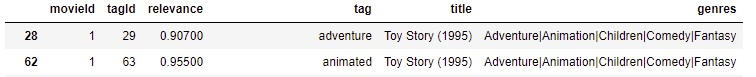

In [8]:
#Insert your code here

movielens_tags = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\MBD II\\Term 2\\Recommendation Systems\\ml-latest-small\\genome-tags.csv')
movielens_score = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\MBD II\\Term 2\\Recommendation Systems\\ml-latest-small\\genome-scores.csv')
hashed_tags = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\MBD II\\Term 2\\Recommendation Systems\\ml-latest-small\\tags.csv')

In [9]:
df_tags = pd.merge(movielens_score, movielens_tags, on='tagId', how='inner')

In [10]:
df_tags.head()

,movieId,tagId,relevance,tag
0,1,1,0.02900,007
1,2,1,0.03625,007
2,3,1,0.04150,007
3,4,1,0.03350,007
4,5,1,0.04050,007


In [11]:
df_tags = pd.merge(df_tags, movielens_meta)

In [12]:
df_tags = df_tags.sort_values(by='relevance', ascending=False);

In [13]:
df_tags.head()

,movieId,tagId,relevance,tag,title,genres
7227364,55805,269,1.0,crime gone awry,Before the Devil Knows You're Dead (2007),Crime|Drama|Thriller
6604455,38038,16,1.0,aardman studios,Wallace & Gromit in The Curse of the Were-Rabb...,Adventure|Animation|Children|Comedy
8298024,89028,457,1.0,goretastic,Don't Be Afraid of the Dark (2010),Horror|Thriller
1384008,1639,1081,1.0,view askew,Chasing Amy (1997),Comedy|Drama|Romance
7547463,64285,16,1.0,aardman studios,Wallace and Gromit in 'A Matter of Loaf and De...,Animation|Comedy


In [14]:
df_tags = pd.DataFrame(df_tags.to_records())

## Exercise
Inspect the dataframe for movieId==1 (Toy Story). Do you think all the tags are useful?

In [15]:
df_tags.loc[df_tags['movieId']==1]

,index,movieId,tagId,relevance,tag,title,genres
288,1035,1,1036,0.99950,toys,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
582,243,1,244,0.99900,computer animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2352,785,1,786,0.99550,pixar animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5945,63,1,64,0.98875,animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6018,588,1,589,0.98850,kids and family,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...,...
9769116,1098,1,1099,0.00375,waste of time,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
9775852,592,1,593,0.00350,kurosawa,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
9804658,1068,1,1069,0.00300,vampires,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
9837722,488,1,489,0.00225,hannibal lecter,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


---
**Observation**

Observing the results from Toy Story made us consider that we were using incorrectly the `merge`formula since, as one can see from the Toy Story tags, some correspond to other movies (such as "hannibal lecter" - it would a a dark version of Toy Story). So, reviewing the csv we noticed that the `tagID` within the `geonames-score` file is repeated for each movie. Hence, this leads to having every tag from `geonames-tags` to be applied to every movie. 

In short, it is clear that not all tags are useful and a threshold of relevance should be contemplated to improve the tag-movie association.

---

## Exercise

Solve the previous problem to reduce data and explain the solution.

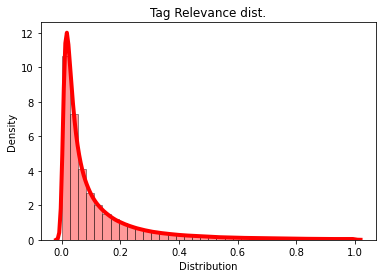

In [61]:
#Inser your code here

sns.distplot(df_tags['relevance'], hist=True, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set(title='Tag Relevance dist.', xlabel='Distribution');

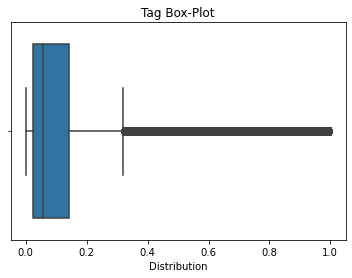

In [58]:
sns.boxplot(df_tags['relevance']).set(title='Tag Box-Plot', xlabel='Distribution');

---

In this case we are interested in the outliers since most of the tags are replicated for movies that do not match - leading to a lower-bound concentration of relevance. So a first exploratory approach will consists in filtering at the relevance threshold of 0.45. This will allow us to concentrate only on the `outliers` (removing also those close to the 3rd quartile border) so as to focus on the relevant tags.


---

In [16]:
df_tags= df_tags.loc[df_tags['relevance']>0.45]

In [17]:
df_tags.loc[df_tags['movieId']==1].sort_values(by='relevance').head(20)

,index,movieId,tagId,relevance,tag,title,genres
515430,259,1,260,0.45025,courage,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
495953,471,1,472,0.45925,greed,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
495939,337,1,338,0.45925,earnest,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
492177,899,1,900,0.46100,sentimental,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
489814,776,1,777,0.46225,pg-13,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
487919,674,1,675,0.46300,movielens top pick,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
480116,633,1,634,0.46675,masterpiece,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
470816,839,1,840,0.47125,realistic,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
463916,169,1,170,0.47475,buddy movie,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
460596,552,1,553,0.47650,intense,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


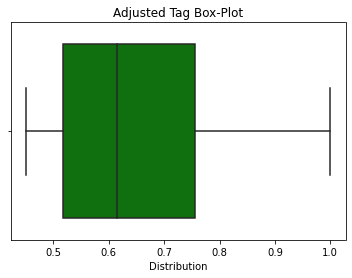

In [42]:
sns.boxplot(df_tags['relevance'], color='green', whis=3).set(title='Adjusted Tag Box-Plot', xlabel='Distribution');

---
**Conclusion**

Looking at the last 20 tags in terms of relevance, we can observe that the result by applying this filtering method allows to obtain more adecquate tags. From the table above we can see that the tags are relatable to Toy Story and, while one might agree more or less with the displayed tags - these are the least relevant within our filtered dataset. 

From the `Adjusted Tag Box-Plot` we can observe that the outliers were removed and, while the distribution is still skewed to the left, most of the remaining tags are around a 0.6 relevance. 

In conclusion, using the `relevance`variable as a proxy for tags association with the corresponding movies and focusing on the "outliers" we are able to improve better associate the tags to the movies

---

### NLP Tags Model

We are going to create the model using the tags and some Natural Language Processing methods to convert the words into vectors to create a metric to compare between those words. We are going to use the packages: gensim and nltk for this purpose.

In [13]:
!pip install gensim

In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
tags_corpus = df_tags.tag.values

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
stop_words = stopwords.words('english')

# tokenize document and clean
def word_tokenize_clean(doc):
  
  # split into lower case word tokens
    tokens = word_tokenize(doc.lower())
  
  # remove tokens that are not alphabetic (including punctuation) and not a stop word
    tokens = [word for word in tokens if word.isalpha() and not word in stop_words]
  
    return tokens

We create a list of Documments. Each document represents a film and it has the tags of that film. 

In [18]:
tags_doc = [TaggedDocument(words=word_tokenize_clean(D), tags=[str(i)]) for i, D in enumerate(tags_corpus)]

We are using Doc2Vec to create a vector representation of each film

In [19]:
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=0) # paragraph vector distributed bag-of-words (PV-DBOW)

model.build_vocab(tags_doc)

We train the model to represent the films in vectors.

In [20]:
max_epochs = 50

for epoch in range(max_epochs):
    print(epoch, end = ' ')
    model.train(tags_doc,
              total_examples=model.corpus_count,
              epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

We compare films by measuring distances among vectors.

In [21]:
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("my_doc2vec_model")
model.save(fname)
model = Doc2Vec.load(fname)

In [18]:
mv = 'Toy Story (1995)'


tags_vectors = model.docvecs.vectors
mv_index = df_tags[df_tags["title"] == mv].index.values[0]

print(tags_vectors[mv_index])

sims = model.docvecs.most_similar(positive = [mv_index], topn = 30)

for i, j in sims:
    print(int(i))
    print(df_tags.loc[int(i), "title"].strip())

[-0.4431296  -0.2755932   0.35998845 -0.8959691   0.0538905   0.6917551
  0.03817422 -0.11424474 -0.77291274  0.03505353 -0.3489764  -0.21530871
 -0.23150055  0.5290028  -0.00982933 -0.35252434  0.10747249  0.15429758
 -0.06387248  0.00729368]
84806
Incredibles, The (2004)
349027
Wreck-It Ralph (2012)
126917
Finding Dory (2016)
287445
Honey, I Shrunk the Kids (1989)
170473
Jack-Jack Attack (2005)
17694
The Lego Movie (2014)
393266
Jurassic Park (1993)
305148
How the Grinch Stole Christmas! (1966)
508680
Care Bears Movie II: A New Generation (1986)
23646
Bug's Life, A (1998)
438162
Gremlins (1984)
68455
Santa Claus: The Movie (1985)
156113
Cars 3 (2017)
506059
Great Mouse Detective, The (1986)
106581
It's the Great Pumpkin, Charlie Brown (1966)
58342
Cars 2 (2011)
22194
Rudolph, the Red-Nosed Reindeer (1964)
414788
Christmas Story, A (1983)
152658
Dolls (1987)
259377
Charlie Brown Christmas, A (1965)
115639
Monsters University (2013)
42883
Toys (1992)
39315
Finding Nemo (2003)
235846
Th

---

**Observation**

Using NLP we can observe some interesting movie recommendations where, by incorporating the tags into the analysis, we are able to observe movies that one can associate with Disney's movie: Toy Story.

The only strange selection within the list is Gremlins, which could traumatize some kids with the green monsters - reason for which the movie is PG-13 -, all-in-all the selection made by this approach is more than interesting as a recommender system. This algorithm works, after reviewing the code and documentation by generating a vector for each tag and a document vector for each movie and later, in the inference stage, the different vectors are weighted to calculate the proximity in order to deploy recommendations.

A way to improve this selection would consist in increasing the number of tags in the dataset which would increase the number of relevant vectors, creating as a result better associations between movies.

---

#### Adding a Pickle handler

To avoid running the entire code for the vectos a pickle was added for this step.

In [4]:
import pickle # Avoids running the model several times by saving it

In [24]:
# Cleans previous pickle
with open('../Recommendation Engines/Group Assignment II - Team H.pkl', 'wb') as f:
    pickle.dump(model, f)

In [5]:
# Loads saved pickle
with open('../Recommendation Engines/Group Assignment II - Team H.pkl','rb') as f:
    loaded_model = pickle.load(f)

model = loaded_model

# Optional

Create any other model that you think could be useful.

For example, you could create a training matrix for predicting the rating as if you were in a machine learning problem. Evaluate your results

---

### Creating an implicit feedback rating predictor

Throughout the assignments and course on Recommendations Engines, we have studied different ways in which feedback from users can be processed in order to create relevant and serendipitous recommendations. 

For this optional exercice, we decided to attempt and develop an implicit rating recommendations system using the Movielens dataset. The objective of our model consists in using the movies that the different user watched as a proxy to build our recommendations and predict if the user will watch a movie or not - seeking to measure interaction of users and movies.

We managed to build a somewhat interesting neural network model by refurbishing code from previous assignments and matching it with other resources available online.

In [38]:
!pip install torch
!pip install pytorch-lightning

  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.8.3
    Uninstalling fsspec-0.8.3:
      Successfully uninstalled fsspec-0.8.3


In [3]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl

**Adjusting the Data**

To determine the interactions of the user with the movie we will extract from the title/rating the year of the movie and the timestamp in which the tag was created by the user for the different corresponding movies.

In [19]:
# Convert date from UNIX to datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'],unit='s')

In [22]:
# Extracting the year from the title
data['year'] =  data['title'].str.extract('.*\((.*)\).*')

#adjusting the row which was: "2006-2007" causing an error
data.at[16913,'year']= 2006 
data['year'] = data['year'].apply(pd.to_numeric)

In [23]:
# Creating a ranking for movies according to the year of release
data['latest'] = data.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

In [24]:
# Separating the data in terms of when they last rated by the user as a proxy of interest and change in interest
train_ratings = data[data['latest'] != 1]
test_ratings = data[data['latest'] == 1]

# With the rankings use - we will focus on a user based rating approach
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

In [25]:
train_ratings.loc[:, 'rating'] = 1

**Negative Interaction**

Since all the data in Movielens consists of a positive class (movies the users did interact) we need to create a negative class also (movies the user is not interested in). To achieve that we will create an arbitrarly chosen sample of 4:1 negative interaction - an assumption that these movies are not interesting for the user. The following code builds that sample for us:



In [26]:
# Get a list of all movie IDs
all_movieIds = data['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with

user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in user_item_set:
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

**Converting the dataset into a Pytorch Class**

To apply the deep-learning for our implicit rating model the dataset is converted into a PyTorch dataset as follows:

In [27]:
class MovieLensTrainDataset(Dataset):
    
    """MovieLens PyTorch Dataset for Training
    
    Args:
        data: Dataframe containing the movie ratings
        all_movieIds: List containing all movieIds
    
    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

**Model: Neural Collaborative Filtering**

Following the model proposed by He et al. (https://arxiv.org/abs/1708.05031) we constructed the following deep-learning model. This model uses the concept of embeddings which allow to convert the different user preferences space into a lower dimensional one (in this case 8 dimensions) and then place users with similar movie preferences near each other to make the corresponding movie interest predictions: 

In [28]:
class NCF(pl.LightningModule):
    
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer: Use of function to obtain most probable classes
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float()) 
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=0)

**Model Training**

In [29]:
# Check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Since our device does not have available GPU's to train the model we will use the CPU

In [30]:
num_users = data['userId'].max()+1
num_items = data['movieId'].max()+1
all_movieIds = data['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

trainer = pl.Trainer(max_epochs=5, gpus=0, reload_dataloaders_every_epoch=True,
                     progress_bar_refresh_rate=1, logger=False, checkpoint_callback=False)

trainer.fit(model)

C:\Users\nicol\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:49: LightningDeprecationWarning: `reload_dataloaders_every_epoch` is deprecated in v1.4 and will be removed in v1.6. Please use `reload_dataloaders_every_n_epochs` in Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 4.9 K 
1 | item_embedding | Embedding | 1.5 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.228     Total estimated model params size (MB)


In [36]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = data.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in test_user_item_set:
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio for 10 movies is: {:.2f}%".format(np.average(hits)*100))

The Hit Ratio for 10 movies is: 60.33%


---
**Observation**

By using a deep-learning method, we managed to build an implicit learning model where, based on users viewings - not ratings - we recommended other movies and then measured if they interacted with the item or not. With this dataset and results, we established that:

- **60% of the users were recommended an actual item they interacted, within a 10 movie list.** 

The objective we set out consisted in building a model that seeked to understand and measure user item interaction as a way of establishing/learning how this interaction could be factored into recommendations. With a 60% of success rate, this exercise provided and practical way of understanding how implicit learning can be measured and the challenges of building such models. 

This particular model, which could be further improved, allows companies such as Netflix or YouTube to create a recommendation algorithm for those users who are non-raters but still use the streaming platforms.


*When ranking by year of release of the movie a 55% hit ratio was obtained. Combining the user rating and year of release of the movie could potentially improve the hit ratio obtained even further*.

---